In [207]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import shuffle
from matplotlib import pyplot
import seaborn as sns
from collections import Counter
%matplotlib inline

In [181]:
ufc_ml_df = pd.read_csv('ufc_ml_df.csv', sep=';')

In [182]:
# Descriptive statistics
ufc_ml_df.describe()

,win,diff_h,diff_w,diff_r,diff_byear
count,1180.000000,1180.000000,1180.000000,1180.00000,1180.000000
mean,0.500000,-0.062712,-0.285593,-0.05000,-0.032064
std,0.500212,2.522059,7.908229,3.27196,5.228441
min,0.000000,-10.000000,-60.000000,-12.00000,-15.937357
25%,0.000000,-2.000000,0.000000,-2.00000,-3.625673
50%,0.500000,-0.000000,0.000000,0.00000,-0.039700
75%,1.000000,2.000000,0.000000,2.00000,3.482618
max,1.000000,12.000000,60.000000,14.00000,17.596528


In [183]:
# Before shuffling
ufc_ml_df.head()

,win,winner,loser,diff_h,diff_w,diff_r,diff_byear
0,1,Marlon Vera,Rob Font,0.0,0,1,-5.440221
1,1,Andrei Arlovski,Jake Collier,0.0,-10,1,9.722308
2,1,Joanderson Brito,Andre Fili,3.0,0,2,-4.632539
3,1,Grant Dawson,Jared Gordon,-1.0,0,-4,-5.456649
4,1,Darren Elkins,Tristan Connelly,0.0,0,-3,1.574297


In [184]:
# Shuffling the dataframe
ufc_ml_df = shuffle(ufc_ml_df, random_state=1)

In [185]:
# After shuffling
ufc_ml_df.head()

,win,winner,loser,diff_h,diff_w,diff_r,diff_byear
660,0,Randy Brown,Alex Oliveira,4.0,0,2,2.376503
548,1,Jonathan Martinez,Thomas Almeida,-1.0,10,0,-2.721480
1063,0,Serghei Spivac,Greg Hardy,-2.0,-5,-2,6.491578
321,1,Billy Quarantillo,Spike Carlyle,-2.0,0,1,4.408030
1055,0,Jamahal Hill,Johnny Walker,-2.0,0,-3,-0.865179


<AxesSubplot:>

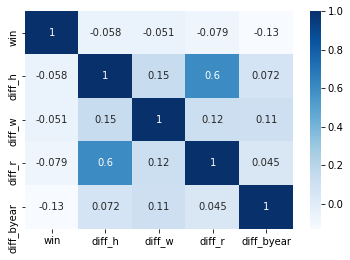

In [222]:
# Correlation between variables
corrMatrix = ufc_ml_df[['win', 'diff_h', 'diff_w', 'diff_r', 'diff_byear']].corr()
sns.heatmap(corrMatrix, annot=True,
        xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns, cmap="Blues")
# We see that height and reach are highly correlated. 
# This violates assumptions of the logistic model, so in order to fix this I will use l2 regularization.

In [186]:
# Result signifies whether the fighter won
result = np.array(ufc_ml_df['win'])

counter = Counter(result)

# I won't use diff_weight, since most of the time it's equal to zero.
# It also could be very large, since some fighters change weight divisions.

ufc_df_expl = ufc_ml_df.drop(['win', 'winner', 'loser', 'diff_w'], axis=1)

expl = np.array(ufc_df_expl)

In [188]:
# Splitting data
train_ufc, test_ufc, train_result, test_result = train_test_split(expl, result, test_size = 0.2, random_state = 50)

In [189]:
# Checking the shapes of data after splitting
print('Training UFC dataset Shape:', train_ufc.shape)
print('Training Result Shape:', train_result.shape)
print('Testing UFC dataset Shape:', test_ufc.shape)
print('Testing Result Shape:', test_result.shape)

Training UFC dataset Shape: (944, 3)
Training Result Shape: (944,)
Testing UFC dataset Shape: (236, 3)
Testing Result Shape: (236,)


# Random Forest

In [195]:
rf = RandomForestClassifier(n_estimators=50, bootstrap = True, max_features=None)

rf.fit(train_ufc, train_result)

rf_predictions = rf.predict(test_ufc)
rf_errors = abs(rf_predictions - test_result)

rf_probs = rf.predict_proba(test_ufc)[:, 1]
roc_value = roc_auc_score(test_result, rf_probs)

print('Mean Absolute Error:', round(np.mean(rf_errors), 2))
print("Random Forest score: ", rf.score(test_ufc, test_result))
print('ROC AUC:', round(np.mean(roc_value), 2))

Mean Absolute Error: 0.44
Random Forest score:  0.5635593220338984
ROC AUC: 0.56


In [196]:
print(classification_report(test_result, rf_predictions))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       136
           1       0.49      0.59      0.53       100

    accuracy                           0.56       236
   macro avg       0.57      0.57      0.56       236
weighted avg       0.58      0.56      0.57       236



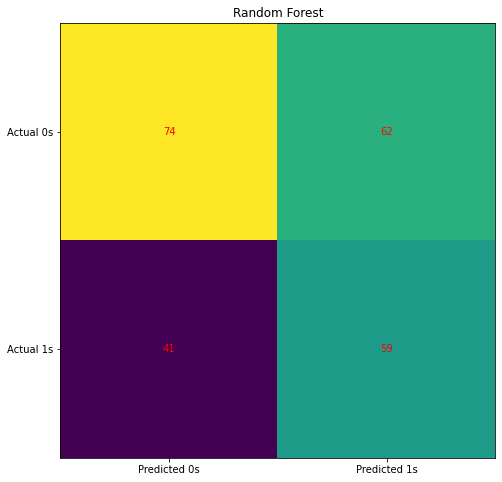

In [197]:
# Confusion matrix heat map for random forest
cm_rf = confusion_matrix(test_result, rf_predictions)

fig, ax = pyplot.subplots(figsize=(8, 8))
ax.imshow(cm_rf)
ax.grid(False)
ax.set_title('Random Forest')
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_rf[i, j], ha='center', va='center', color='red')
pyplot.show()

# Logistic Regression

In [232]:
# l2 penalization is applied, because of the high correlation of variables diff_h and diff_r
log_model = LogisticRegression(penalty = 'l2', solver='liblinear', C=10, random_state=0)
log_model.fit(train_ufc, train_result)
log_predictions = log_model.predict(test_ufc)
log_errors = abs(log_predictions - test_result)
log_probs = log_model.predict_proba(test_ufc)[:, 1]
roc_value = roc_auc_score(test_result, log_probs)

print('Mean Absolute Error:', round(np.mean(log_errors), 2))
print("Logistic model score: ", log_model.score(test_ufc, test_result))
print('ROC AUC:', round(np.mean(roc_value), 2))

Mean Absolute Error: 0.43
Logistic model score:  0.5720338983050848
ROC AUC: 0.6


In [233]:
# Based on the coefficients, relationship between features and labels is inverse. This was also seen on the correlation heatmap.
# Surprisingly, the coefficients suggest that taller fighters with more reach are at a disadvantage. 
# The coefficient for age is reasonable as it implies that younger fighters perform better.
print('Coefficients')
print('Difference in height: ', log_model.coef_[0][0])
print('Difference in reach: ', log_model.coef_[0][1])
print('Difference in age: ', log_model.coef_[0][2])

Coefficients
Difference in height:  -0.015118161796267699
Difference in reach:  -0.03509896106094533
Difference in age:  -0.05023919518478876


In [200]:
print(classification_report(test_result, log_predictions))

              precision    recall  f1-score   support

           0       0.69      0.46      0.56       136
           1       0.50      0.72      0.59       100

    accuracy                           0.57       236
   macro avg       0.59      0.59      0.57       236
weighted avg       0.61      0.57      0.57       236



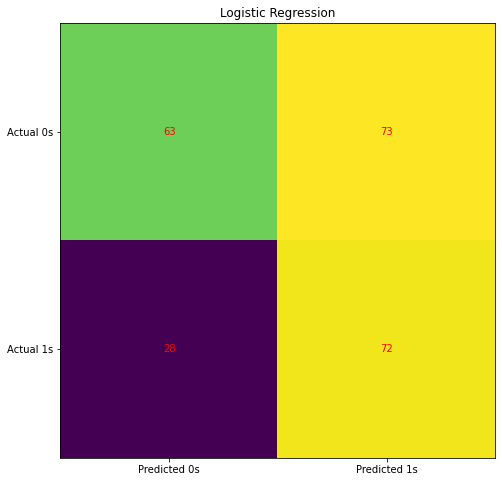

In [201]:
# Confusion matrix heat map for logistic regression
cm_log = confusion_matrix(test_result, log_predictions)

fig, ax = pyplot.subplots(figsize=(8, 8))
ax.imshow(cm_log)
ax.grid(False)
ax.set_title('Logistic Regression')
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_log[i, j], ha='center', va='center', color='red')
pyplot.show()

# K nearest neighbours

In [202]:
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(train_ufc, train_result)
knn_predictions = knn.predict(test_ufc)
knn_errors = abs(knn_predictions-test_result)
knn_probs = knn.predict_proba(test_ufc)[:, 1]
roc_value = roc_auc_score(test_result, knn_probs)

print('Mean Absolute Error:', round(np.mean(knn_errors), 2))
print("K nearest neighbours score: ", knn.score(test_ufc, test_result))
print('ROC AUC:', round(np.mean(roc_value), 2))

Mean Absolute Error: 0.47
K nearest neighbours score:  0.5254237288135594
ROC AUC: 0.51


In [203]:
print(classification_report(test_result, knn_predictions))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       136
           1       0.44      0.46      0.45       100

    accuracy                           0.53       236
   macro avg       0.52      0.52      0.52       236
weighted avg       0.53      0.53      0.53       236



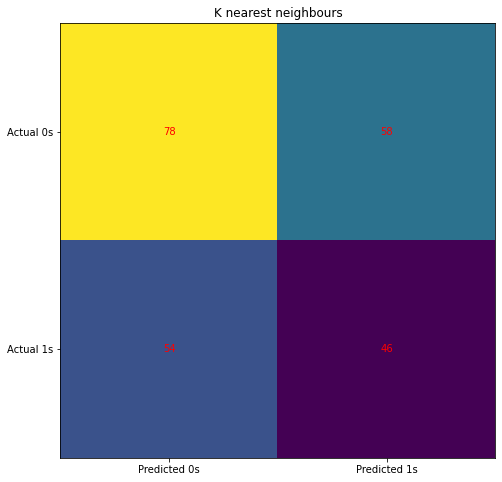

In [204]:
# Confusion matrix heat map for k nearest neighbours method
cm_neighbour = confusion_matrix(test_result, knn_predictions)

fig, ax = pyplot.subplots(figsize=(8, 8))
ax.imshow(cm_neighbour)
ax.grid(False)
ax.set_title('K nearest neighbours')
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_neighbour[i, j], ha='center', va='center', color='red')
pyplot.show()